https://www.kaggle.com/christopherwsmith/how-to-predict-lung-cancer-levels-100-accuracy

The purpose of this notebook is to demonstrate a quick method of using feature selection to skip over most EDA and just get the important features we need for machine learning. an exploratory data analysis (EDA) . Data was selected by KBest ANOVA F-ratio. Support vector machines (SVM) was used with hyper parameterization by grid and randomized searchers for the most accurately built models.

General relevant modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting Functions
import matplotlib.pyplot as plt

#Aesthetics
!pip install seaborn --upgrade #Update Seaborn for Plotting
import seaborn as sns
sns.set_style('ticks') #No grid with ticks

ERROR: Invalid requirement: '#Update'


In [2]:
#Data Import
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

First lets import the xlsx file then convert it to csv. Then after lets take a quick look for null values and features.

In [6]:
cancer=pd.read_excel('./input/CancerPatientDataSets.xlsx', header=None)
#To use the data we will need to fix the header
new_header=cancer.iloc[0]#Reads the first row which contains the headers
cancer=cancer[1:]#Slices the rest of the data frame from header
cancer.columns=new_header#Sets the header labels
cancer.info()
cancer.head()
cancer_label=cancer.columns
for label in cancer_label:
    print('***', label,'labels:',cancer[label].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 1 to 1000
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Patient Id                1000 non-null   object
 1   Age                       1000 non-null   object
 2   Gender                    1000 non-null   object
 3   Air Pollution             1000 non-null   object
 4   Alcohol use               1000 non-null   object
 5   Dust Allergy              1000 non-null   object
 6   OccuPational Hazards      1000 non-null   object
 7   Genetic Risk              1000 non-null   object
 8   chronic Lung Disease      1000 non-null   object
 9   Balanced Diet             1000 non-null   object
 10  Obesity                   1000 non-null   object
 11  Smoking                   1000 non-null   object
 12  Passive Smoker            1000 non-null   object
 13  Chest Pain                1000 non-null   object
 14  Coughing of Blood       

We can see that all of the data is numerical with age as int, level as categories and the rest are ordinal. Luckily, we do not need to worry about data cleaning here as there are no nulls. Lets directly jump into EDA.


EDA
First lets set up a consistent plotting function called plotter.


Plotter Function
(Read red indents below def function for understanding of code)

In [8]:
def Plotter(plot, x_label, y_label, x_rot=None, y_rot=None,  fontsize=12, fontweight=None, legend=True, save=False,save_name=None):
    """
    Helper function to make a quick consistent plot with few easy changes for aesthetics.
    Input:
    plot: sns or matplot plotting function
    x_label: x_label as string
    y_label: y_label as string
    x_rot: x-tick rotation, default=None, can be int 0-360
    y_rot: y-tick rotation, default=None, can be int 0-360
    fontsize: size of plot font on axis, defaul=12, can be int/float
    fontweight: Adding character to font, default=None, can be 'bold'
    legend: Choice of including legend, default=True, bool
    save: Saves image output, default=False, bool
    save_name: Name of output image file as .png. Requires Save to be True.
               default=None, string: 'Insert Name.png'
    Output: A customized plot based on given parameters and an output file
    
    """
    #Ticks
    ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
    plt.xticks(fontsize=fontsize, fontweight=fontweight, rotation=x_rot)
    plt.yticks(fontsize=fontsize, fontweight=fontweight, rotation=y_rot)

    #Legend
    if legend==True:
        plt.legend()
    else:
        ax.legend().remove()
        
    #Labels
    plt.xlabel(x_label, fontsize=fontsize, fontweight=fontweight, color='k')
    plt.ylabel(y_label, fontsize=fontsize, fontweight=fontweight, color='k')

    #Removing Spines and setting up remianing, preset prior to use.
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(3)
    
    if save==True:
        plt.savefig(save_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Level', ylabel='Count'>

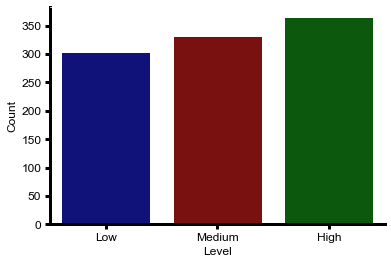

In [9]:
fig, ax=plt.subplots()#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.countplot(data=cancer, x='Level', palette=['darkblue','darkred','darkgreen'])#Count plot
Plotter(plot, 'Level', 'Count', legend=None, save=True, save_name='Level Count.png')#Plotter function for aesthetics
plot

As we can see the data is fairly balanced. Why don't we break it down further by gender.

<AxesSubplot:xlabel='Level', ylabel='Count'>

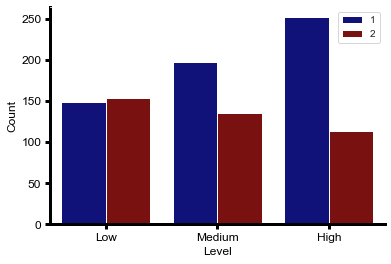

In [10]:
fig, ax=plt.subplots()#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.countplot(data=cancer, x='Level', hue='Gender', palette=['darkblue','darkred'])#Count plot
Plotter(plot, 'Level', 'Count', legend=True, save=True, save_name='Level Count by Gender.png')#Plotter function for aesthetics
plot

We have a higher representation of gender one than gender two. Lets start by looking to see if there is a correlation between some of the data. We can start with alcohol use and fatique and see if the level of cancer is related to them.

<AxesSubplot:xlabel='Alcohol use', ylabel='Fatique'>

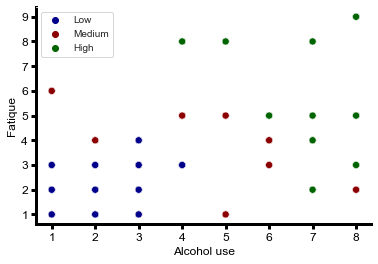

In [11]:
fig, ax=plt.subplots()#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.scatterplot(data=cancer, x='Alcohol use',y='Fatigue', hue='Level', palette=['darkblue','darkred','darkgreen'], s=50, marker='o')#Count plot
Plotter(plot, 'Alcohol use', 'Fatique', legend=True, save=True, save_name='Level Dependence on Alcohol and Fatigue.png')#Plotter function for aesthetics
plot

There is clearly two different clusters for low and high levels by alcohol use and fatique while medium is a combination of both. Is there a difference by age and level of cancer?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Level', ylabel='Age'>

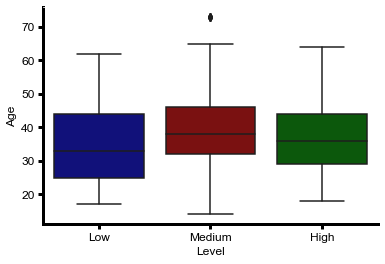

In [12]:
fig, ax=plt.subplots()#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.boxplot(data=cancer, x='Level', y='Age', palette=['darkblue','darkred','darkgreen'])#Count plot
Plotter(plot, 'Level', 'Age', legend=False, save=True, save_name='Level by Age.png')#Plotter function for aesthetics
plot

Looking at the box-plot, age is not to important on level of cancer. Though there are a lot of variables to look at we can we can just find the most important ones by using the SelectKBest Algorithm with ANOVA F-ratio statistic.

Feature Selection
This method will generate the F-ratio scores of all features and we can determine which ones to use for machine learning.

In [13]:
from sklearn.feature_selection import SelectKBest #Feature Selector
from sklearn.feature_selection import f_classif #F-ratio statistic for categorical values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Score', ylabel='Feature'>

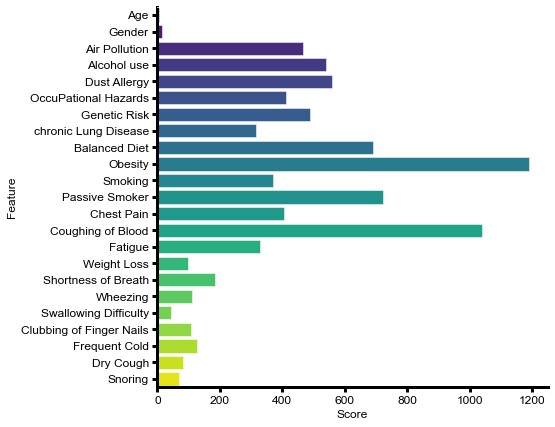

In [14]:
#Feature Selection
X=cancer.drop(['Level','Patient Id'], axis=1)
Y=cancer['Level']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis',linewidth=0.5, saturation=2, orient='h')
Plotter(plot, 'Score', 'Feature', legend=False, save=True, save_name='Feature Importance.png')#Plotter function for aesthetics
plot

We will take all the features that scored more than 200 as they show the least redundancy.

In [15]:
#Selection method
selection=featureScores[featureScores['Score']>=200]#Selects features that scored more than 200
selection=list(selection['Feature'])#Generates the features into a list
selection.append('Level')#Adding the Level string to be used to make new data frame
new_cancer=cancer[selection] #New dataframe with selected features
new_cancer.head() #Lets take a look at the first 5

,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,Smoking,Passive Smoker,Chest Pain,Coughing of Blood,Fatigue,Level
1,2,4,5,4,3,2,2,4,3,2,2,4,3,Low
2,3,1,5,3,4,2,2,2,2,4,2,3,1,Medium
3,4,5,6,5,5,4,6,7,2,3,4,8,8,High
4,7,7,7,7,6,7,7,7,7,7,7,8,4,High
5,6,8,7,7,7,6,7,7,8,7,7,9,3,High


As we can see, 13 features were selected and we created a new data frame to account for them. We can now start the process of preprocessing for machine learning application.

Splitting the Data
First, the data will be split so we can train a scaler model to apply to an unknwon (test) data set. We will save 25% of the data for testing.

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(new_cancer.drop(['Level'], axis=1), new_cancer['Level'],test_size=0.25, random_state=0)

#Checking the shapes
print("X_train shape :",X_train.shape)
print("Y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",y_test.shape)

X_train shape : (750, 13)
Y_train shape : (750,)
X_test shape : (250, 13)
Y_test shape : (250,)


Scaling Preprocessing
Next, the data will be scaled by the standard scaler function in the sklearn package using the formula  z=Xo−μσ . This can help reduce the effect of outliers when modeling later.

In [17]:
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()

X_train_scaled=scaler.fit_transform(X_train) #Scaling and fitting the training set to a model
X_test_scaled=scaler.transform(X_test) #Transformation of testing set based off of trained scaler model

Machine Learning with SVM and Grid/Randomization Search
For modeling we will use the support vector machines classifiers (SVC). The SVC's can handle higher dimensional data and genearte hyperplanes for separation and score on a yes (1) no (1) basis. The rulings are decided for where a data point lands within a decision boundary. We can evalute multiple parameters at one using Grid or Randomization Search functions. Grid Search evalutes several input parameters at all combinations input while randomized search looks for the best. Cross-validation is the models self assemessment when trying to find the best parameters on the training data and can be done in "n" amount of replicates. We will set up two functions: one for the searches and the other for the confusion matrices.

In [18]:
from sklearn.svm import SVC #Classifier
#Packages
"""These packages are required for the functions below
"""
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV #Paramterizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Accuracy metrics
import itertools #Used for iterations

Search Function
(Read red indents below def function for understanding of code)

In [19]:
def Searcher(estimator, param_grid, search, train_x, train_y, test_x, test_y,label=None):
    """
    This is a helper function for tuning hyperparameters using the two search methods.
    Methods must be GridSearchCV or RandomizedSearchCV.
    Inputs:
        estimator: Any Classifier
        param_grid: Range of parameters to search
        search: Grid search or Randomized search
        train_x: input variable of your X_train variables 
        train_y: input variable of your y_train variables
        test_x: input variable of your X_test variables
        test_y: input variable of your y_test variables
        label: str to print estimator, default=None
    Output:
        Returns the estimator instance, clf
        
    Modified from: https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random#To-standardize-or-not-to-standardize
    
    """   
    
    try:
        if search == "grid":
            clf = GridSearchCV(
                estimator=estimator, 
                param_grid=param_grid, 
                scoring=None,
                n_jobs=-1, 
                cv=10, #Cross-validation at 10 replicates
                verbose=0,
                return_train_score=True
            )
        elif search == "random":           
            clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=10,
                verbose=0,
                random_state=1,
                return_train_score=True
            )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0) #Exits program if not grid or random
        
    # Fit the model
    clf.fit(X=train_x, y=train_y)
    
    #Testing the model
    
    try:
        if search=='grid':
            cfmatrix=confusion_matrix(
            y_true=test_y, y_pred=clf.predict(test_x))
        
            #Defining prints for accuracy metrics of grid
            print("**Grid search results of", label,"**")
            print("The best parameters are:",clf.best_params_)
            print("Best training accuracy:\t", clf.best_score_)
            print('Classification Report:')
            print(classification_report(y_true=test_y, y_pred=clf.predict(test_x))
             )
        elif search == 'random':
            cfmatrix=confusion_matrix(
            y_true=test_y, y_pred=clf.predict(test_x))

            #Defining prints for accuracy metrics of grid
          
            print("**Random search results of", label,"**")
            print("The best parameters are:",clf.best_params_)
            print("Best training accuracy:\t", clf.best_score_)
            print('Classification Report:')
            print(classification_report(y_true=test_y, y_pred=clf.predict(test_x))
             )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0) #Exits program if not grid or random
        
    return clf, cfmatrix; #Returns a trained classifier with best parameters

Confusion Matrix Function
(Read red indents below def function for understanding of code)

In [20]:
def plot_confusion_matrix(cm, label,color=None,title=None):
    """
    Plot for Confusion Matrix:
    Inputs:
        cm: sklearn confusion_matrix function for y_true and y_pred as seen in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        title: title of confusion matrix as a 'string', default=None
        label: the unique label that represents classes for prediction can be done as sorted(dataframe['labels'].unique()).
        color: confusion matrix color, default=None, set as a plt.cm.color, based on matplot lib color gradients
    """
    
    classes=sorted(label)
    plt.imshow(cm, interpolation='nearest', cmap=color)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black") 

Modeling

C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39

**Grid search results of SVC Grid **
The best parameters are: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 1}
Best training accuracy:	 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        91
         Low       1.00      1.00      1.00        85
      Medium       1.00      1.00      1.00        74

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

____________________________________________________________________________________________________


C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\mirza\AppData\Local\Programs\Python\Python39\l

**Random search results of SVC Random **
The best parameters are: {'random_state': 1, 'kernel': 'rbf', 'gamma': 0.86, 'C': 0.61}
Best training accuracy:	 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        91
         Low       1.00      1.00      1.00        85
      Medium       1.00      1.00      1.00        74

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



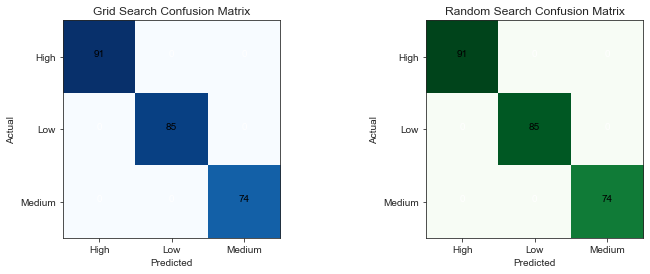

In [21]:
svm_param = {
    "C": [.01, .1, 1, 5, 10, 100], #Specific parameters to be tested at all combinations
    "gamma": [0, .01, .1, 1, 5, 10, 100],
    "kernel": ["rbf","linear""poly"],
    "random_state": [1]}

#Randomized Grid Search SVM Parameters
svm_dist = {
    "C": np.arange(0.01,2, 0.01),   #By using np.arange it will select from randomized values
    "gamma": np.arange(0,1, 0.01),
    "kernel": ["rbf","linear""poly"],
    "random_state": [1]}

"""
Following the code above, we can set the parameters for both grid search and randomized search. The grid search will evaluate all specified 
parameters while the randomized search will look at the parameters labeled in random order at the best training accuracy. The np.arange function
allows for a multitude of points to be looked at between the set start and end values of 0.01 to 2. """

#Grid Search SVM
svm_grid, cfmatrix_grid= Searcher(SVC(), svm_param, "grid", X_train_scaled, y_train, X_test_scaled, y_test,label='SVC Grid')

print('_____'*20)#Spacer

#Random Search SVM
svm_rand, cfmatrix_rand= Searcher(SVC(), svm_dist, "random", X_train_scaled, y_train, X_test_scaled, y_test,label='SVC Random')

#Plotting the confusion matrices
plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title='Random Search Confusion Matrix',label=new_cancer['Level'].unique(), color=plt.cm.Greens) #grid matrix function
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title='Grid Search Confusion Matrix', label=new_cancer['Level'].unique(), color=plt.cm.Blues) #randomized matrix function

plt.savefig('confusion.png')

As we can see both searches provided 100% accuracy. Similarly, using the metric of an f1-score there was 100% accuracy showing that the model is very well built.

Conclusion
We observed that:

Many features have some prominent separation alone for distincting the level of cancer.
Using KBestSelection we were able to use the most important features from the data set
The 13 selected features provided 100% accuracy when modeled with either Grid/Randomized Searches on support vector machine classifier.